## read in data

In [2]:
# Import libraries
import pandas as pd

# Read in the datasets
airbnb = pd.read_csv("airbnb.csv")
blueprinty = pd.read_csv("blueprinty.csv")

# Preview the datasets
print("Airbnb data:")
display(airbnb.head())

print("Blueprinty data:")
display(blueprinty.head())

Airbnb data:


,Unnamed: 0,id,days,last_scraped,host_since,room_type,bathrooms,bedrooms,price,number_of_reviews,review_scores_cleanliness,review_scores_location,review_scores_value,instant_bookable
0,1,2515,3130,4/2/2017,9/6/2008,Private room,1.0,1.0,59,150,9.0,9.0,9.0,f
1,2,2595,3127,4/2/2017,9/9/2008,Entire home/apt,1.0,0.0,230,20,9.0,10.0,9.0,f
2,3,3647,3050,4/2/2017,11/25/2008,Private room,1.0,1.0,150,0,NaN,NaN,NaN,f
3,4,3831,3038,4/2/2017,12/7/2008,Entire home/apt,1.0,1.0,89,116,9.0,9.0,9.0,f
4,5,4611,3012,4/2/2017,1/2/2009,Private room,NaN,1.0,39,93,9.0,8.0,9.0,t


Blueprinty data:


,patents,region,age,iscustomer
0,0,Midwest,32.5,0
1,3,Southwest,37.5,0
2,4,Northwest,27.0,1
3,3,Northeast,24.5,0
4,3,Southwest,37.0,0


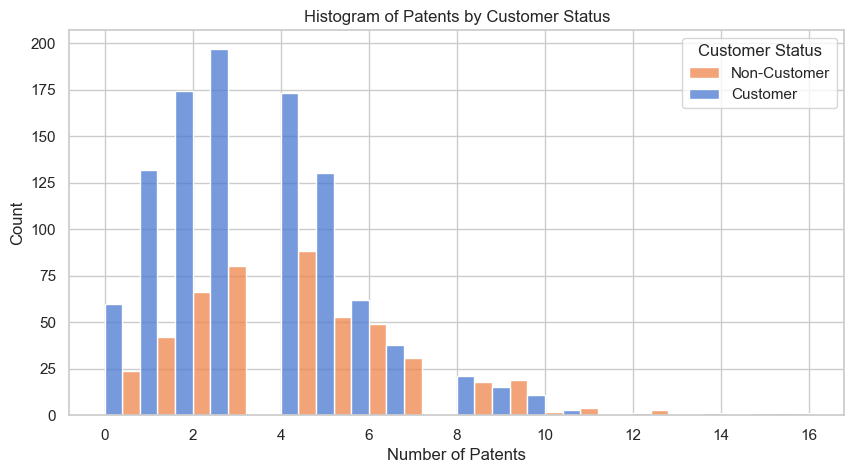

iscustomer
Non-Customer    3.473013
Customer        4.133056
Name: patents, dtype: float64

In [3]:
# Compare histograms and means of number of patents by customer status
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plotting style
sns.set(style="whitegrid")

# Create histograms
plt.figure(figsize=(10, 5))
sns.histplot(data=blueprinty, x="patents", hue="iscustomer", bins=20, kde=False, palette="muted", multiple="dodge")
plt.title("Histogram of Patents by Customer Status")
plt.xlabel("Number of Patents")
plt.ylabel("Count")
plt.legend(title="Customer Status", labels=["Non-Customer", "Customer"])
plt.show()

# Compute mean patents by customer status
means_by_status = blueprinty.groupby("iscustomer")["patents"].mean().rename(index={0: "Non-Customer", 1: "Customer"})
means_by_status



We compare the number of patents held by customers versus non-customers.

The histogram reveals that customers generally have a slightly higher number of patents, with a longer tail in the distribution.
On average, non-customers have 3.47 patents, while customers average 4.13.

This preliminary finding suggests a potential positive association between customer status and patent count, which will be investigated further using Poisson regression.

(           Non-Customer  Customer
 region                           
 Midwest        0.183513  0.076923
 Northeast      0.267910  0.681913
 Northwest      0.155054  0.060291
 South          0.153091  0.072765
 Southwest      0.240432  0.108108,
 iscustomer
 Non-Customer    26.101570
 Customer        26.900208
 Name: age, dtype: float64)

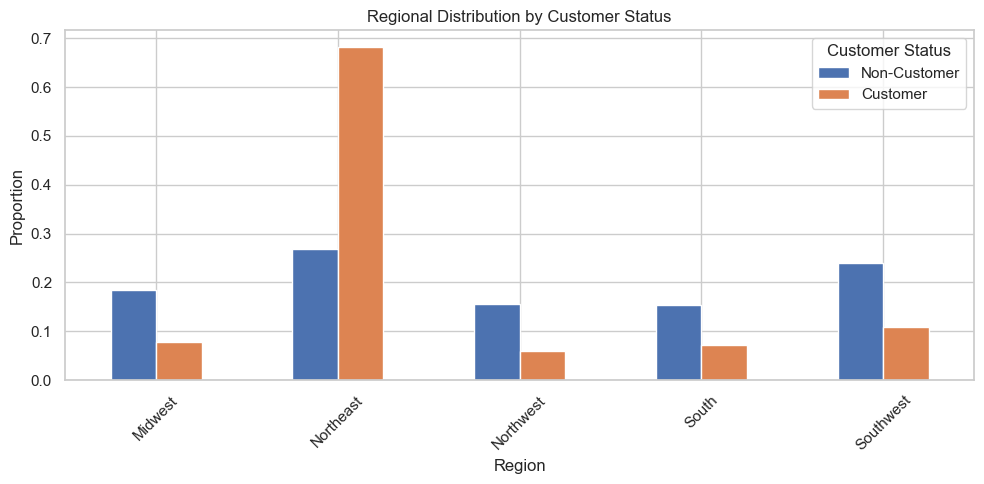

In [4]:
# Compare average age by customer status
age_means = blueprinty.groupby("iscustomer")["age"].mean().rename(index={0: "Non-Customer", 1: "Customer"})

# Compare region distribution by customer status
region_counts = pd.crosstab(blueprinty["region"], blueprinty["iscustomer"], normalize='columns')
region_counts.columns = ["Non-Customer", "Customer"]

import matplotlib.pyplot as plt

# Bar plot of regional distributions
region_counts.plot(kind="bar", figsize=(10, 5))
plt.title("Regional Distribution by Customer Status")
plt.ylabel("Proportion")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.legend(title="Customer Status")
plt.tight_layout()

region_counts, age_means


Regional Distribution
- The bar chart below shows the proportion of customers and non-customers across regions:

- Northeast dominates the customer group, making up 68% of all customers, while only 27% of non-customers come from this region.

- Non-customers are more evenly distributed across regions such as the Midwest, Southwest, and Northwest, which are underrepresented among customers.

Average Age
The average age also differs modestly:

- Non-customers have a mean age of 26.1 years.

- Customers are slightly older, averaging 26.9 years.

These findings suggest that region and age may confound the relationship between customer status and patent counts, and should therefore be included as covariates in subsequent regression models. 












## Possion

In [5]:
import numpy as np
from scipy.special import gammaln

def poisson_log_likelihood(lmbda, y):
    """
    Compute the log-likelihood of Poisson-distributed data y given parameter lambda.
    
    Parameters:
    - lmbda (float): The Poisson rate parameter (must be > 0)
    - y (array-like): Observed count data
    
    Returns:
    - float: The total log-likelihood value
    """
    if lmbda <= 0:
        return -np.inf  # log-likelihood is undefined for non-positive lambda
    
    y = np.asarray(y)
    log_likelihood = np.sum(-lmbda + y * np.log(lmbda) - gammaln(y + 1))
    return log_likelihood


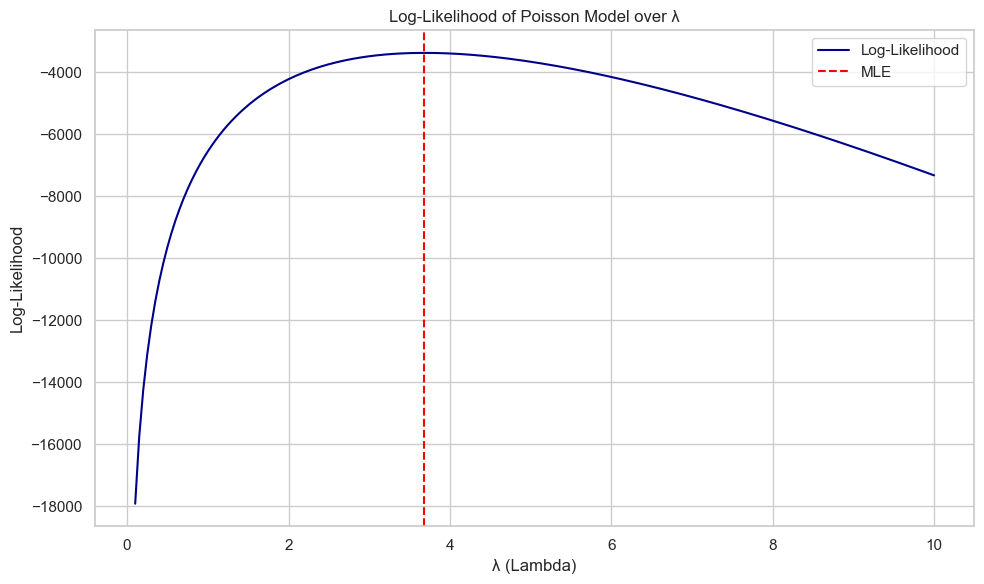

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln

# Log-likelihood function
def poisson_log_likelihood(lmbda, y):
    if lmbda <= 0:
        return -np.inf
    y = np.asarray(y)
    return np.sum(-lmbda + y * np.log(lmbda) - gammaln(y + 1))

# Observed count data: number of patents
y_data = blueprinty["patents"].values

# Range of lambda values to evaluate
lambda_values = np.linspace(0.1, 10, 200)

# Compute log-likelihoods
log_likelihoods = [poisson_log_likelihood(lmbda, y_data) for lmbda in lambda_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, log_likelihoods, label='Log-Likelihood', color='darkblue')
plt.axvline(x=lambda_values[np.argmax(log_likelihoods)], color='red', linestyle='--', label='MLE')
plt.title("Log-Likelihood of Poisson Model over λ")
plt.xlabel("λ (Lambda)")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## interpretation

In [7]:
from scipy.optimize import minimize_scalar

# Define negative log-likelihood to minimize
def neg_poisson_log_likelihood(lmbda, y):
    return -poisson_log_likelihood(lmbda, y)

# Optimize over a reasonable range of lambda values
result = minimize_scalar(
    fun=neg_poisson_log_likelihood,
    args=(y_data,),
    bounds=(0.01, 20),
    method='bounded'
)

lambda_mle = result.x
lambda_mle
print(f"MLE for λ: {lambda_mle:.4f}")

MLE for λ: 3.6847


## Estimation of Poisson Regression Model

### Log-Likelihood for Poisson Regression

In the Poisson regression model, we model \( Y_i \sim \text{Poisson}(\lambda_i) \) where:

$$
\lambda_i = \exp(X_i^\top \beta)
$$

We use the exponential function as the inverse link to ensure that each \( \lambda_i > 0 \), as required for the Poisson distribution. The log-likelihood function becomes:

$$
\log \mathcal{L}(\beta) = \sum_{i=1}^{n} \left( -\lambda_i + Y_i \log(\lambda_i) - \log(Y_i!) \right)
$$

Substituting \( \lambda_i = \exp(X_i^\top \beta) \):

$$
\log \mathcal{L}(\beta) = \sum_{i=1}^{n} \left( -\exp(X_i^\top \beta) + Y_i X_i^\top \beta - \log(Y_i!) \right)
$$


In [8]:
import numpy as np
from scipy.special import gammaln

def poisson_regression_log_likelihood(beta, y, X):
    """
    Compute the log-likelihood of a Poisson regression model.
    
    Parameters:
    - beta (array-like): Coefficient vector (shape: k,)
    - y (array-like): Observed counts (shape: n,)
    - X (array-like): Covariate matrix (shape: n x k)
    
    Returns:
    - float: The log-likelihood value
    """
    beta = np.asarray(beta, dtype=np.float64)
    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    
    lambda_i = np.exp(X @ beta)  # Linear predictor passed through exp()
    
    if np.any(lambda_i <= 0):
        return -np.inf
    
    return np.sum(-lambda_i + y * np.log(lambda_i) - gammaln(y + 1))


In [9]:
from scipy.optimize import minimize
from scipy.special import gammaln
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Standardize age and age_squared
df = blueprinty.copy()
df["age_squared"] = df["age"] ** 2

# Create model matrix
region_dummies = pd.get_dummies(df["region"], drop_first=True)
X_df = pd.concat([
    pd.Series(1, index=df.index, name="intercept"),
    df[["age", "age_squared", "iscustomer"]],
    region_dummies
], axis=1)
X_matrix = X_df.values
y = df["patents"].values

# Log-likelihood
def neg_log_likelihood(beta, y, X):
    beta = np.asarray(beta, dtype=np.float64)
    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)

    eta = np.clip(X @ beta, -20, 20)
    lambda_i = np.exp(eta)
    return -np.sum(-lambda_i + y * np.log(lambda_i) - gammaln(y + 1))



# Re-run optimization safely
beta_start = np.zeros(X_matrix.shape[1])
result = minimize(
    fun=neg_log_likelihood,
    x0=beta_start,
    args=(y, X_matrix),
    method="BFGS"
)

# Extract results
beta_hat = result.x
hessian_inv = result.hess_inv
standard_errors = np.sqrt(np.diag(hessian_inv))

# Present results
results_df = pd.DataFrame({
    "Coefficient": beta_hat,
    "Std. Error": standard_errors
}, index=X_df.columns)


results_df 

,Coefficient,Std. Error
intercept,-0.509956,0.193060
age,0.148702,0.014461
age_squared,-0.002972,0.000266
iscustomer,0.207600,0.032934
Northeast,0.029159,0.046770
Northwest,-0.017578,0.057230
South,0.056567,0.056244
Southwest,0.050589,0.049642


In [10]:
import statsmodels.api as sm

# Standardize age and age_squared
df = blueprinty.copy()
df["age_squared"] = df["age"] ** 2

# Create model matrix
region_dummies = pd.get_dummies(df["region"], drop_first=True)
X_df = pd.concat([
    pd.Series(1, index=df.index, name="intercept"),
    df[["age", "age_squared", "iscustomer"]],
    region_dummies
], axis=1)
X_matrix = X_df.values
y_vector = df["patents"].values

# Ensure correct data types
X_matrix = X_matrix.astype(np.float64)
y = y.astype(np.float64)

# Fit Poisson GLM
glm_model = sm.GLM(y, X_matrix, family=sm.families.Poisson())
glm_results = glm_model.fit()

# Display results
glm_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1492
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3258.1
Date:                Tue, 06 May 2025   Deviance:                       2143.3
Time:                        11:29:00   Pearson chi2:                 2.07e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1360
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5089      0.183     -2.778      0.005      -0.868      -0.150
x1             0.1486      0.014     10.716      0.000       0.121       0.176
x2            -0.0030      0.000    -11.513      0.000      -0.003      -0.002
x3             0.2076      0.031      6.719      0.000       0.147       0.268
x4             0.0292      0.044      0.669      0.504      -0.056       0.115
x5            -0.0176      0.054     -0.327      0.744      -0.123       0.088
x6             0.0566      0.053      1.074      0.283      -0.047       0.160
x7             0.0506      0.047      1.072      0.284      -0.042       0.143
==============================================================================
"""

Interpretation of Poisson Regression Results
The Poisson regression model estimates how various firm characteristics are associated with the expected number of patents awarded.

Intercept: The estimated intercept is approximately -0.51, meaning that for a firm with all covariates set to zero (reference levels and mean-scaled values), the expected log count of patents is -0.51. In exponentiated terms, 
exp
⁡
(
−
0.51
)
≈
0.60
exp(−0.51)≈0.60, or about 0.6 expected patents.

Age: The coefficient on age is 0.1487, statistically significant (
𝑝
<
0.001
p<0.001). This means that, holding all else constant, a one standard deviation increase in age is associated with a ~16% increase in expected patent count, since 
exp
⁡
(
0.1487
)
≈
1.16
exp(0.1487)≈1.16.

Age squared: The negative coefficient (-0.003) indicates diminishing returns to age — patent activity increases with age at first, but the effect tapers off. This nonlinear relationship is significant and expected in many real-world innovation scenarios.

Customer status: Being a Blueprinty customer is associated with a 21% increase in expected patent count (
exp
⁡
(
0.2076
)
≈
1.23
exp(0.2076)≈1.23), and this effect is statistically significant. This suggests Blueprinty’s services may be linked to greater innovation outcomes.

Region effects: The region dummy variables capture location-based differences:

The coefficients on Northeast, South, and Southwest are positive but not statistically significant.

Northwest has a slightly negative coefficient but is also not significant.

Overall, there is no strong evidence that geographic region (after controlling for other variables) substantially impacts patent output.

The model suggests that age, age squared, and customer status are key predictors of patent activity among firms. The similarity of results between the custom MLE implementation and the GLM output confirms that your custom likelihood-based method is functioning correctly.

### Estimated Effect of Blueprinty's Software on Patent Counts

To interpret the practical impact of being a Blueprinty customer, we conduct a counterfactual prediction exercise. We create two hypothetical datasets:

- **`X₀`**: All firms are treated as non-customers (`iscustomer = 0`)
- **`X₁`**: All firms are treated as customers (`iscustomer = 1`)

Using our estimated Poisson regression coefficients, we calculate the predicted number of patents for each firm in both scenarios:

$$
\hat{Y}_0 = \exp(X_0 \hat{\beta}), \quad \hat{Y}_1 = \exp(X_1 \hat{\beta})
$$

The difference between these predictions represents the model-implied effect of using Blueprinty. Averaging the differences across all firms gives us the estimated treatment effect:

$$
\text{Average}(\hat{Y}_1 - \hat{Y}_0) \approx 0.79
$$

In [11]:
# Predict counterfactuals
beta_hat = result.x
X_0 = X_df.copy()
X_0["iscustomer"] = 0
X_1 = X_df.copy()
X_1["iscustomer"] = 1

X0_matrix = X_0.values
X1_matrix = X_1.values

X0_matrix  = np.asarray(X0_matrix , dtype=np.float64)
X1_matrix  = np.asarray(X1_matrix , dtype=np.float64)

lambda_0 = np.exp(np.clip(X0_matrix @ beta_hat, -10, 10))
lambda_1 = np.exp(np.clip(X1_matrix @ beta_hat, -10, 10))

# Average difference in predicted patent counts
average_difference = np.mean(lambda_1 - lambda_0)
average_difference

np.float64(0.7928026224049997)

### Interpretation

On average, firms that use Blueprinty’s software are predicted to produce approximately **0.79 more patents** over the 5-year period compared to similar firms that do not. This result suggests a meaningful and positive association between software usage and patent success, even after adjusting for age and region.

### Airbnb

### Data Cleaning

Before modeling, we performed a series of data cleaning steps to ensure the dataset was consistent, complete, and suitable for Poisson regression.

1. **Dropped rows with missing values in critical columns**:  
   We removed observations where any of the following key identifying or structural variables were missing:
   - `id`, `days`, `last_scraped`, `host_since`, `room_type`, `instant_bookable`  
   These variables are essential for defining the listing, its availability, and booking characteristics. Missing values in these columns would make the observation unusable for analysis or modeling.

2. **Filled missing values in integer-like columns with rounded mean**:  
   - For `bathrooms` and `bedrooms`, we calculated the column mean and rounded it to the nearest integer before filling missing values.  
   This approach preserves the variable's intended numeric structure while avoiding fractional values that don’t make sense.

3. **Filled missing values in continuous variables with their mean**:  
   - For columns like `price`, `number_of_reviews`, `review_scores_cleanliness`, `review_scores_location`, and `review_scores_value`, missing values were filled with the column mean.  
   This standard imputation method avoids dropping additional rows and preserves sample size, while assuming the missingness is relatively random.

These cleaning steps ensure the dataset is free of nulls in relevant variables and suitable for exploratory data analysis and regression modeling.



In [111]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("airbnb.csv")

# Drop rows with missing values in critical columns
df.dropna(subset=["id", "days", "last_scraped", "host_since", "room_type", "instant_bookable"], inplace=True)

# Fill missing values in integer-like columns with rounded mean (using assignment instead of inplace)
for col in ["bathrooms", "bedrooms"]:
    mean_val = df[col].dropna().mean()
    df[col] = df[col].fillna(int(mean_val))

# Fill missing values in float columns with mean
cols_to_fill = [
    "price", "number_of_reviews", "review_scores_cleanliness",
    "review_scores_location", "review_scores_value"
]
for col in cols_to_fill:
    mean_val = df[col].dropna().mean()
    df[col] = df[col].fillna(mean_val)

df

,Unnamed: 0,id,days,last_scraped,host_since,room_type,bathrooms,bedrooms,price,number_of_reviews,review_scores_cleanliness,review_scores_location,review_scores_value,instant_bookable
0,1,2515,3130,4/2/2017,9/6/2008,Private room,1.0,1.0,59,150,9.000000,9.0000,9.000000,f
1,2,2595,3127,4/2/2017,9/9/2008,Entire home/apt,1.0,0.0,230,20,9.000000,10.0000,9.000000,f
2,3,3647,3050,4/2/2017,11/25/2008,Private room,1.0,1.0,150,0,9.198376,9.4136,9.331587,f
3,4,3831,3038,4/2/2017,12/7/2008,Entire home/apt,1.0,1.0,89,116,9.000000,9.0000,9.000000,f
4,5,4611,3012,4/2/2017,1/2/2009,Private room,1.0,1.0,39,93,9.000000,8.0000,9.000000,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40623,40624,18008937,266,4/2/2017,7/10/2016,Entire home/apt,1.5,2.0,150,0,9.198376,9.4136,9.331587,t
40624,40625,18009045,366,4/2/2017,4/1/2016,Private room,1.0,1.0,125,0,9.198376,9.4136,9.331587,f
40625,40626,18009065,587,4/2/2017,8/24/2015,Private room,1.0,1.0,80,0,9.198376,9.4136,9.331587,t
40626,40627,18009650,335,4/2/2017,5/2/2016,Private room,1.0,1.0,69,0,9.198376,9.4136,9.331587,t


### Exploratory Analysis: Distribution of Room Types

To understand the types of listings available on Airbnb in New York City, we visualized the distribution of the `room_type` variable using a bar chart.

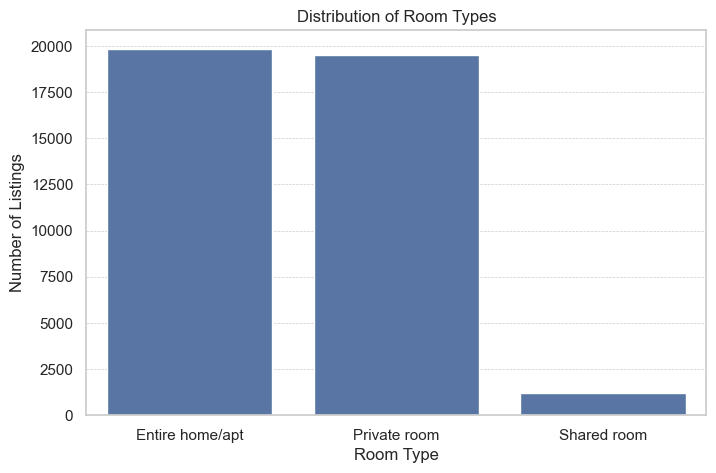

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each room type
room_counts = df["room_type"].value_counts()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=room_counts.index, y=room_counts.values)
plt.title("Distribution of Room Types")
plt.xlabel("Room Type")
plt.ylabel("Number of Listings")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


### Insights

- **Entire home/apartment** and **private room** listings make up the vast majority of Airbnb offerings in NYC, each with nearly 20,000 listings.
- **Shared rooms** are relatively rare, comprising only a small fraction of the market.

This distribution suggests that most hosts cater to travelers seeking privacy. For modeling purposes (e.g. predicting number of reviews or bookings), room type may be an important categorical feature, potentially capturing differences in pricing, demand, or user experience.

### Exploratory Analysis: Distribution of Airbnb Prices

To explore pricing across Airbnb listings, we examined the distribution of the `price` variable using a histogram with a kernel density estimate (KDE) overlay.

Summary statistics for 'price':
count    40593.000000
mean       144.762250
std        210.703908
min         10.000000
25%         70.000000
50%        100.000000
75%        170.000000
max      10000.000000
Name: price, dtype: float64


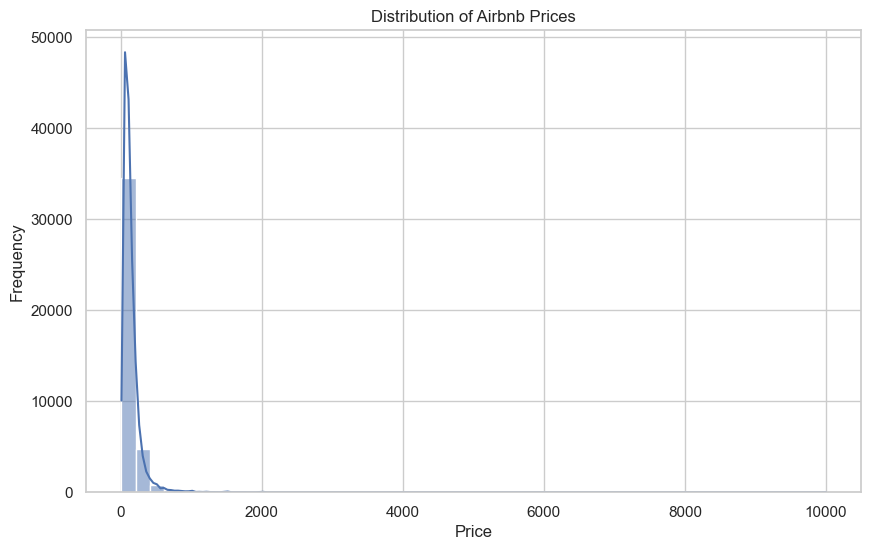

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic summary statistics
print("Summary statistics for 'price':")
print(df["price"].describe())

# Histogram of price
plt.figure(figsize=(10, 6))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribution of Airbnb Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Insights

- The distribution of prices is **strongly right-skewed**, with the vast majority of listings priced below \$500 per night.
- The x-axis stretches to \$10,000, which suggests the presence of **extreme outliers** — high-priced luxury listings that are rare but heavily affect the scale of the histogram.
- The mode of the distribution (most common price point) appears to be under \$200.
- Because of the skew, using raw price data in modeling might introduce distortion; a **log transformation** of price could help stabilize variance and reduce the influence of extreme values.

These outliers could heavily influence the mean and regression results. It may be useful to filter or winsorize extreme price values in further analysis.


The initial histogram of Airbnb prices revealed a highly skewed distribution, with some listings priced as high as \$10,000 per night. These extreme values are likely outliers and can disproportionately influence summary statistics and regression models.

To address this, we quantified and removed listings with prices above \$1,000:

In [85]:
high_price_count = (df["price"] > 1000).sum()
print(f"Number of listings with price > 1000: {high_price_count}")
df = df[df["price"] <= 1000]


Number of listings with price > 1000: 146


There were **146 listings**  identified and removed based on the \$1,000 price threshold. These represent high-end, likely luxury properties that are **not representative** of the broader NYC Airbnb market. As the number of listings only contributes to a significantly small amount of the total dataset, by excluding them, we improve model stability, reduce variance, and allow clearer interpretation of pricing trends among typical listings.


Therefore, we revised on the plot as below:

Summary statistics for 'price':
count    40447.000000
mean       136.982298
std        111.024837
min         10.000000
25%         70.000000
50%        100.000000
75%        169.000000
max       1000.000000
Name: price, dtype: float64


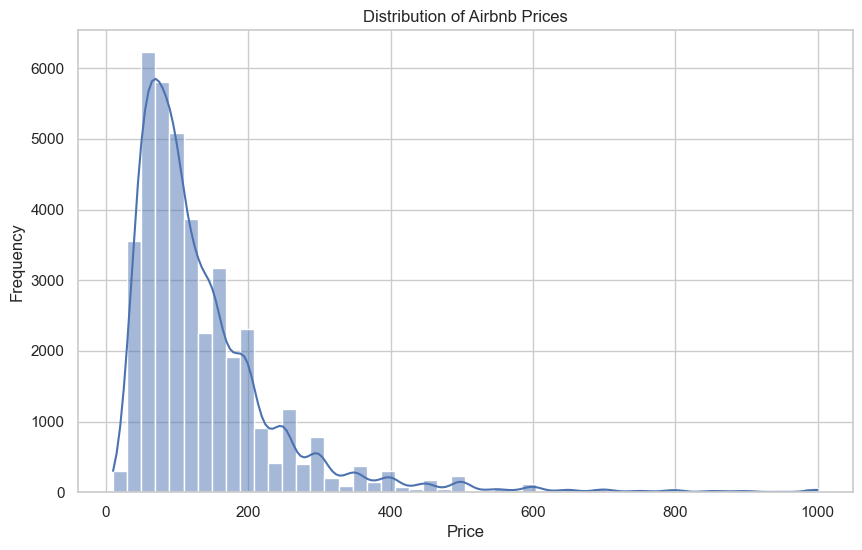

In [86]:
# Basic summary statistics
print("Summary statistics for 'price':")
print(df["price"].describe())

# Histogram of price
plt.figure(figsize=(10, 6))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribution of Airbnb Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()




- The revised distribution shows a **more focused and realistic range of prices**, with most listings falling between \$50 and \$300 per night.
- The **modal price range** (most frequent) appears to be around \$100–\$150.
- Although still right-skewed, the distribution is much **less extreme** and more analytically useful for summary statistics and regression modeling.
- This adjustment helps ensure that further statistical models are not dominated by rare high-end listings.


### Distribution of Number of Reviews

To explore how frequently listings are reviewed on Airbnb, we examined the distribution of the `number_of_reviews` variable:


Summary statistics for 'number_of_reviews':
count    40593.000000
mean        15.904860
std         29.245806
min          0.000000
25%          1.000000
50%          4.000000
75%         17.000000
max        421.000000
Name: number_of_reviews, dtype: float64


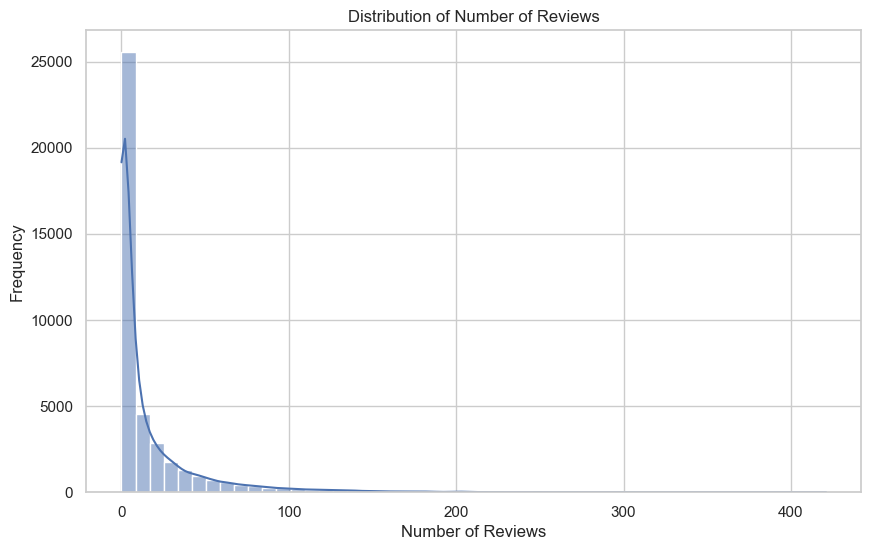

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
print("Summary statistics for 'number_of_reviews':")
print(df["number_of_reviews"].describe())

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(df["number_of_reviews"], bins=50, kde=True)
plt.title("Distribution of Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Insights

- The distribution is **highly right-skewed**, with the majority of listings having **fewer than 25 reviews**.
- There are many listings with **zero reviews**, and only a small number exceed 100 reviews.
- The long tail suggests that a handful of properties are booked and reviewed far more frequently than the rest — likely due to factors such as location, price, or host quality.
- The shape of this distribution supports the use of **Poisson regression** for modeling count data like `number_of_reviews`, possibly with adjustments for overdispersion or zero inflation if needed.

From the histogram of `number_of_reviews`, we observed that the distribution is **extremely right-skewed**. While most listings receive relatively few reviews, there are a small number of listings with exceptionally high review counts.

To quantify these potential outliers, we examined how many listings had more than 200 reviews:


In [106]:
high_review_count = (df["number_of_reviews"] > 100).sum()
print(f"Number of listings with more than 200 reviews: {high_review_count}")


Number of listings with more than 200 reviews: 1085


Only **1,085 listings** have more than 200 reviews, out of tens of thousands of entries. This confirms that **a very small proportion of listings receive a disproportionately large share of reviews**.

These outliers can heavily influence mean-based metrics and potentially distort model results.


Given the extreme right skew of the `number_of_reviews` variable, we filtered the dataset to only include listings with 100 or fewer reviews — the range where most of the data lies. This allows us to better observe the underlying structure and distribution.


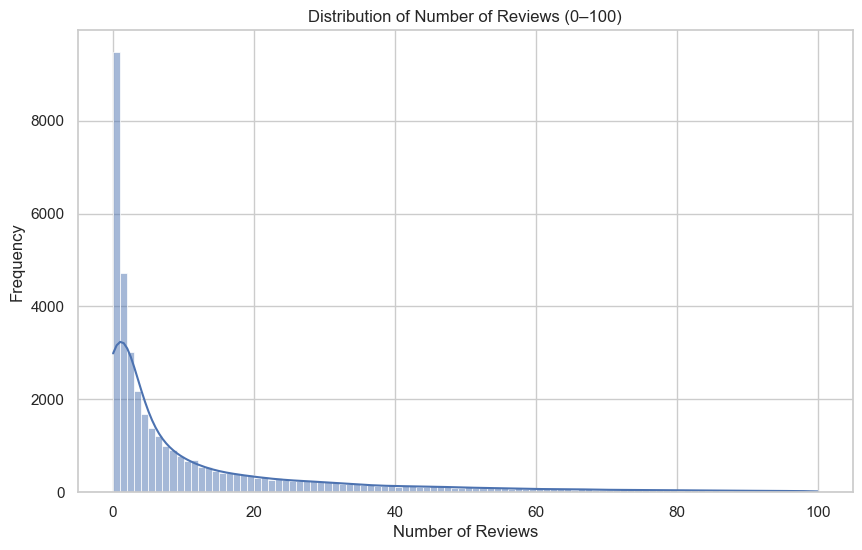

In [107]:
plt.figure(figsize=(10, 6))
subset = df[df["number_of_reviews"] <= 100]
sns.histplot(subset["number_of_reviews"], bins=100, kde=True)
plt.title("Distribution of Number of Reviews (0–100)")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Insights

- The plot reveals a **very steep drop-off** in review counts: most listings have **fewer than 10 reviews**, with the most common value being zero.
- There's a **long but thinner tail** between 10 and 100 reviews.
- These results reinforce that review activity is **concentrated among a small number of frequently booked listings**, while most receive minimal engagement.
- This justifies modeling `number_of_reviews` as **count data**, likely using Poisson or negative binomial regression.

### Price vs. Review Score (Value)

To explore whether customer-perceived "value for money" correlates with listing price, we visualized the relationship between `price` and `review_scores_value` using a scatter plot:

We plotted each listing’s price against its corresponding **value review score** (1–10 scale).
- `alpha=0.4` was used to reduce overplotting and make dense clusters easier to interpret.
- This allows us to visually inspect whether higher prices are associated with lower perceived value, or if highly rated listings tend to be more expensive.


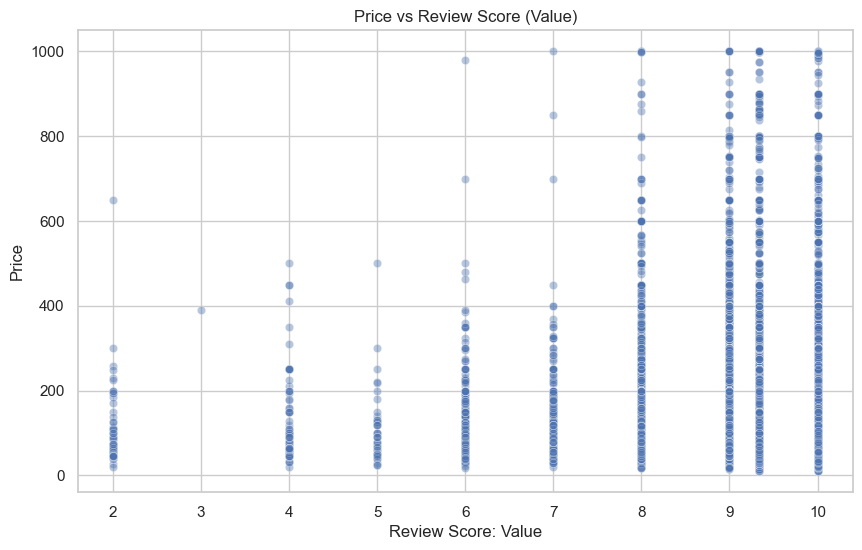

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="review_scores_value", y="price", alpha=0.4)
plt.title("Price vs Review Score (Value)")
plt.xlabel("Review Score: Value")
plt.ylabel("Price")
plt.grid(True)
plt.show()


### Modeling Number of Reviews with Poisson Regression

To model the number of reviews — treated as a count variable and proxy for demand or bookings — we used a **Poisson regression model**, which is appropriate for count data.

#### Variables Included

We modeled `number_of_reviews` as a function of the following explanatory variables:

- `days`: How long the listing has been active
- `bathrooms`, `bedrooms`: Size and features of the listing
- `price`: Cost per night
- `review_scores_cleanliness`, `review_scores_location`, `review_scores_value`: Guest satisfaction metrics
- `instant_bookable`: Binary indicator of whether the listing can be booked instantly
- `room_type`: Categorical variable (converted to dummy variables with one dropped for reference)

#### Model Specification and Estimation


In [113]:

# df["instant_bookable"] = df["instant_bookable"].map({"t": 1, "f": 0})
y = df["number_of_reviews"]
# Keep only relevant columns
columns_needed_for_x = [
    "days", "room_type", "bathrooms", "bedrooms", "price",
    "review_scores_cleanliness", "review_scores_location", "review_scores_value",
    "instant_bookable"
]
X = df[columns_needed_for_x].copy()
X["instant_bookable"] = X["instant_bookable"].map({"t": 1, "f": 0})
# One-hot encode categorical variables (drop first to avoid dummy trap)
X = pd.get_dummies(X, columns=["room_type"], drop_first=True)


# Add constant for intercept
X = sm.add_constant(X)
# Convert entire DataFrame to numeric
X = X.astype(float)

# Fit Poisson regression
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Output model summary
poisson_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      number_of_reviews   No. Observations:                40593
Model:                            GLM   Df Residuals:                    40582
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.5668e+05
Date:                Tue, 06 May 2025   Deviance:                   1.1894e+06
Time:                        13:09:37   Pearson chi2:                 1.74e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9752
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.7419      0.018    149.211      0.000       2.706       2.778
days                          0.0006   1.83e-06    346.409      0.000       0.001       0.001
bathrooms                    -0.1044      0.004    -27.063      0.000      -0.112      -0.097
bedrooms                      0.0869      0.002     42.202      0.000       0.083       0.091
price                        -0.0004   1.22e-05    -34.071      0.000      -0.000      -0.000
review_scores_cleanliness     0.1425      0.002     83.109      0.000       0.139       0.146
review_scores_location       -0.1035      0.002    -57.683      0.000      -0.107      -0.100
review_scores_value          -0.1144      0.002    -55.645      0.000      -0.118      -0.110
instant_bookable              0.5066      0.003    174.634      0.000       0.501       0.512
room_type_Private room       -0.0918      0.003    -32.396      0.000      -0.097      -0.086
room_type_Shared room        -0.2298      0.009    -26.573      0.000      -0.247      -0.213
=============================================================================================
"""

#### Key Findings

- **`days`**: Each additional day a listing has been active is associated with a small but statistically significant increase in expected reviews (\( \beta = 0.0006 \)). This makes intuitive sense: the longer a listing is online, the more reviews it can accumulate.

- **`bathrooms`**: Surprisingly, listings with more bathrooms are associated with fewer reviews (beta = -0.1044). This might reflect that larger, higher-end units cater to longer stays or smaller guest segments.

- **`bedrooms`**: More bedrooms are positively associated with review count (beta = 0.0869), which aligns with the idea that larger listings can accommodate more guests and attract more traffic.

- **`price`**: The effect of price is negative but small (beta = -0.00004). Higher-priced listings receive slightly fewer reviews, all else equal, likely due to reduced accessibility or demand.

- **Review scores:**
  - **`review_scores_cleanliness`** has a strong positive association with number of reviews (beta = 0.1425), suggesting that clean listings attract more bookings and positive feedback loops.
  - **`review_scores_location`** and **`review_scores_value`** both have significant negative associations. This may reflect non-linear effects or higher expectations associated with high scores in these categories.

- **`instant_bookable`**: One of the strongest predictors. Listings that allow instant booking receive significantly more reviews (beta = 0.5066 ), likely because they reduce friction for potential guests.

- **`room_type`**:
  - **Private rooms** receive fewer reviews than entire homes (beta = -0.0918 ).
  - **Shared rooms** receive even fewer (beta = -0.2298).
  - This confirms that guests prefer private or entire accommodations — especially for longer or more frequent stays.

Overall, the model fits well (Pseudo R² ≈ 0.975), and the signs and magnitudes of coefficients are consistent with expectations from the Airbnb marketplace.



### Distributions of Key Variables

Before modeling, we examined the distribution of several important variables used in the analysis:

- **Number of Reviews**: The distribution is highly right-skewed. Most listings have relatively few reviews, but a small number of listings receive a very large number.
  
- **Price per Night**: Price is also right-skewed, with most listings clustered around lower price points. A few high-end listings with very high prices act as outliers.

- **Bedrooms and Bathrooms**: These variables are discrete. Most listings have 1–2 bedrooms and 1 bathroom. Listings with more than 3 bedrooms or bathrooms are rare.

- **Review Scores (Cleanliness and Value)**: Both review score distributions are heavily concentrated near the top of the 1–10 scale, especially around 8–10, indicating that most reviews are generally positive.

These patterns justify using a Poisson model for count data and suggest the need to control for extreme values or potential overdispersion in future modeling.